# Exercise 6.6 

### This script contains the following:¶
#### 01. Importing your libraries and data
#### 02. Subsetting, wrangling, and cleaning time-series data
#### 03. Time series analysis: decomposition
#### 04. Testing for stationarity
#### 05. Stationarizing the Federal Reserve Economic Data

# 01 Importing Libraries and Data

In [1]:
# import libraries

import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [21]:
# Importing the Australian Bureau of Meteorology. Data "Minimum Daily Temperatures Dataset" variable.

# URL of the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'



In [23]:
# Load the dataset
df = pd.read_csv(url, header=0, parse_dates=['Date'], index_col='Date')


In [25]:
df.head(10)

Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8
1981-01-06  15.8
1981-01-07  15.8
1981-01-08  17.4
1981-01-09  21.8
1981-01-10  20.0

In [41]:
df.tail(10)

Temp
Date            
1990-12-22  13.2
1990-12-23  13.9
1990-12-24  10.0
1990-12-25  12.9
1990-12-26  14.6
1990-12-27  14.0
1990-12-28  13.6
1990-12-29  13.5
1990-12-30  15.7
1990-12-31  13.0

In [27]:
df.shape

(3650, 1)

In [31]:
df.columns

Index(['Temp'], dtype='object')

In [33]:
df.dtypes

Temp    float64
dtype: object

In [37]:
type(df)

pandas.core.frame.DataFrame

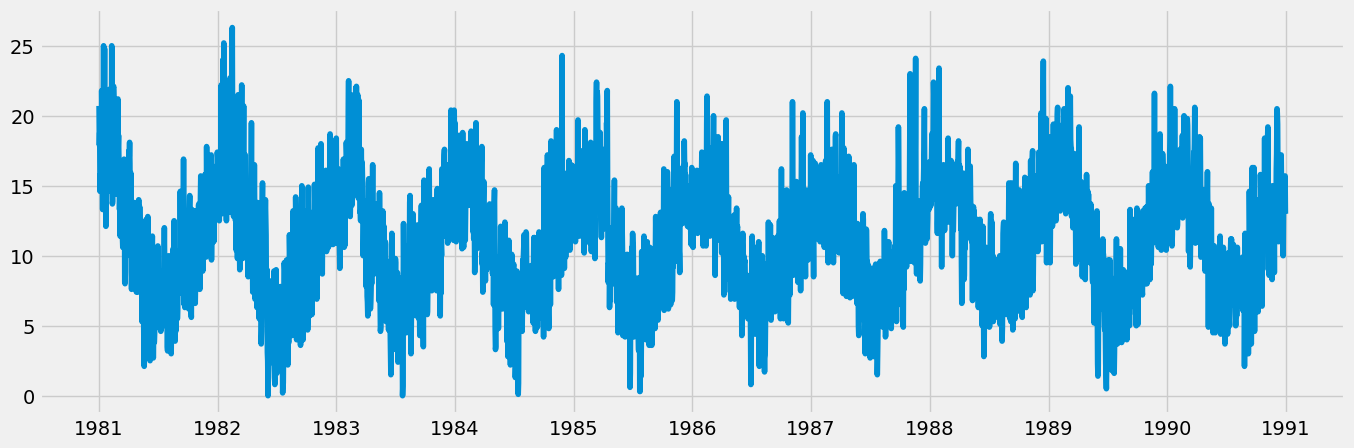

In [39]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)

plt.plot(df)

# 02 Subsetting, Wrangling and Cleaning Time Series Data

In [73]:
# reset index so that you can use the 'Date' column as a filter

df_1 = df.reset_index()

In [75]:
df_1.head(10)

Date  Temp
0 1981-01-01  20.7
1 1981-01-02  17.9
2 1981-01-03  18.8
3 1981-01-04  14.6
4 1981-01-05  15.8
5 1981-01-06  15.8
6 1981-01-07  15.8
7 1981-01-08  17.4
8 1981-01-09  21.8
9 1981-01-10  20.0

In [77]:
df_sub = df_1.loc[(df_1['Date'] >= '1985-01-01') & (df_1['Date'] < '1991-12-31')]

In [79]:
df_sub.head()

Date  Temp
1460 1985-01-01  13.3
1461 1985-01-02  15.2
1462 1985-01-03  13.1
1463 1985-01-04  12.7
1464 1985-01-05  14.6

In [81]:
df_sub.shape

(2190, 2)

In [83]:
# Set the "Date" column as the index

from datetime import datetime

df_sub['datetime'] = pd.to_datetime(df_sub['Date']) # Create a datetime column from "Date.""
df_sub = df_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
df_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
df_sub.head()

Temp
datetime        
1985-01-01  13.3
1985-01-02  15.2
1985-01-03  13.1
1985-01-04  12.7
1985-01-05  14.6

The dataset was subset to include data from 1985 to 1990. This decision was based  on more recent years to  avoid potential historical anomalies or events that could bias the analysis. This subset includes data over 6 years, which is sufficient for time series analysis without compromising the representativeness of the data.

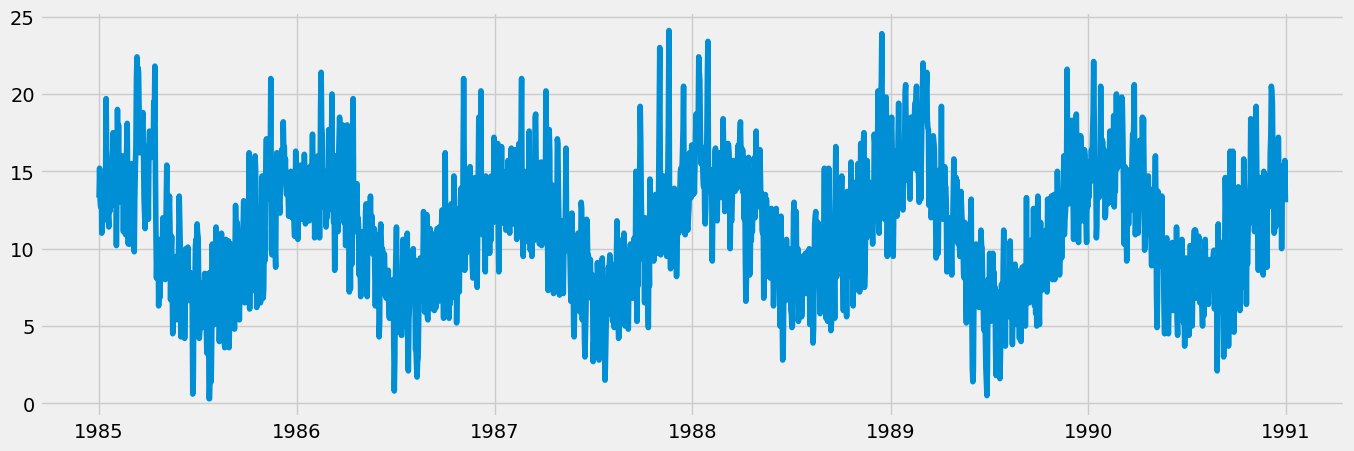

In [85]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_sub)

In [90]:
# check for missing values

df_sub.isnull().sum()

Temp    0
dtype: int64

In [96]:
# check for duplicates

dups = df_sub.duplicated()

In [98]:
dups.sum()

np.int64(1984)

# 03. Time-Series Analysis: Decomposition

In [101]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df_sub, model='additive', period=365)

In [103]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

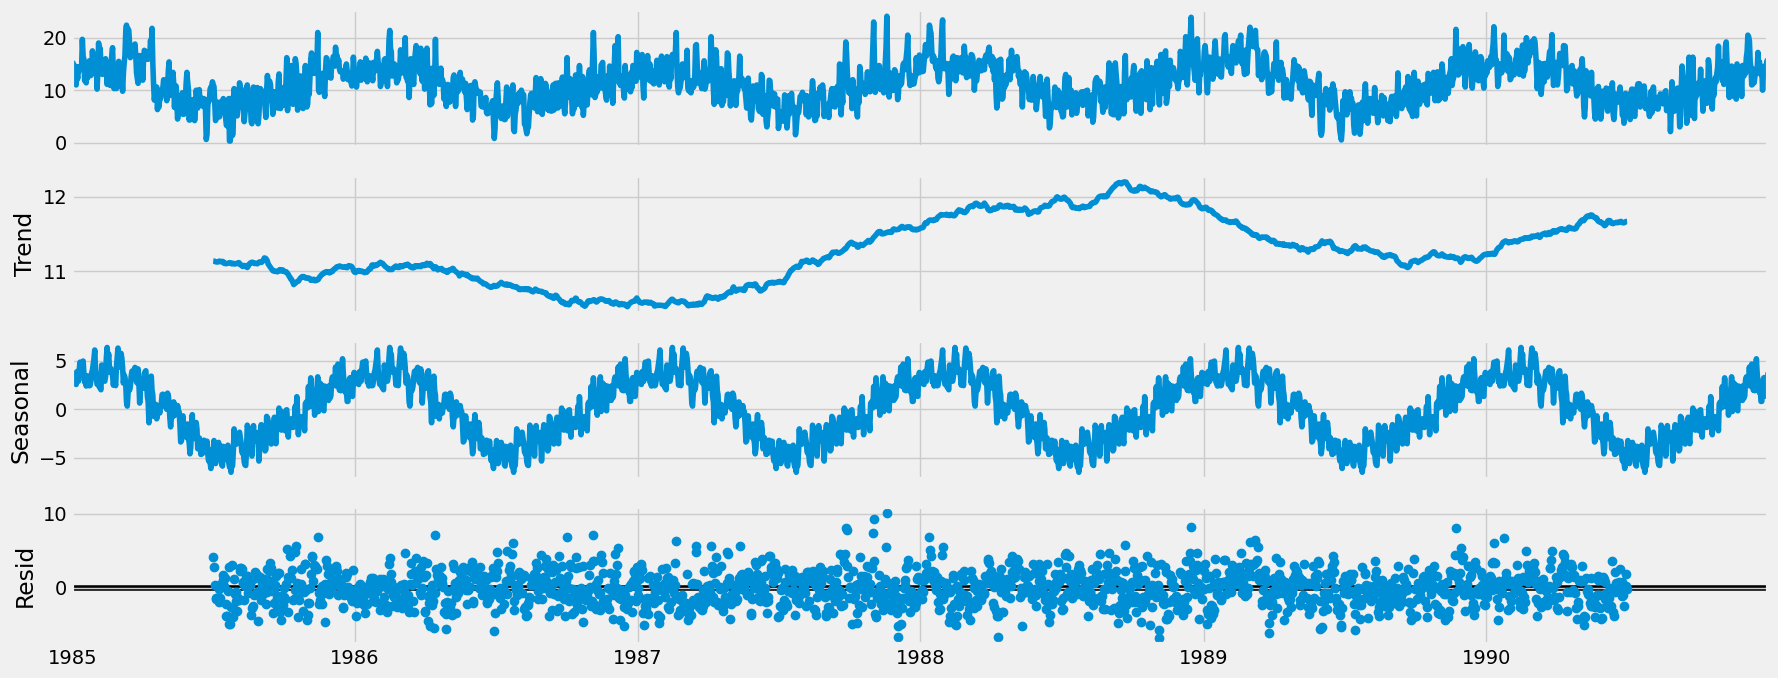

In [105]:
# Plot the separate components

decomposition.plot()
plt.show()

Observed (Top Panel)
The observed panel shows the original data for daily minimum temperatures. It highlights a clear up-and-down pattern over time, which reflects the seasonal changes in temperature. This regular fluctuation is expected in weather data, as temperatures naturally vary throughout the year.

Trend (Second Panel)
The trend component illustrates the overall direction of the temperatures over time. From 1985 to around 1988, there is a gradual cooling trend, with temperatures slightly decreasing. After 1988, the trend shifts upward, indicating a slight warming phase. This helps us understand the long-term changes in the data.

Seasonal (Third Panel)
The seasonal component captures the yearly repeating pattern in the temperatures. It clearly shows higher temperatures during the summer months and lower temperatures during the winter months. This repeating cycle is consistent with seasonal weather changes and is a prominent feature of the data.

Residual (Bottom Panel)
The residual component represents the random variations in the data that are not explained by the trend or seasonal patterns. These fluctuations could be due to unexpected weather events or other random factors. The residuals are relatively small and appear random, suggesting that the model effectively captures the main patterns in the data.

# 04. Testing for Stationarity

In [111]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_sub['Temp'])

Dickey-Fuller Stationarity test:
Test Statistic                   -3.157673
p-value                           0.022569
Number of Lags Used              20.000000
Number of Observations Used    2169.000000
Critical Value (1%)              -3.433368
Critical Value (5%)              -2.862873
Critical Value (10%)             -2.567480
dtype: float64


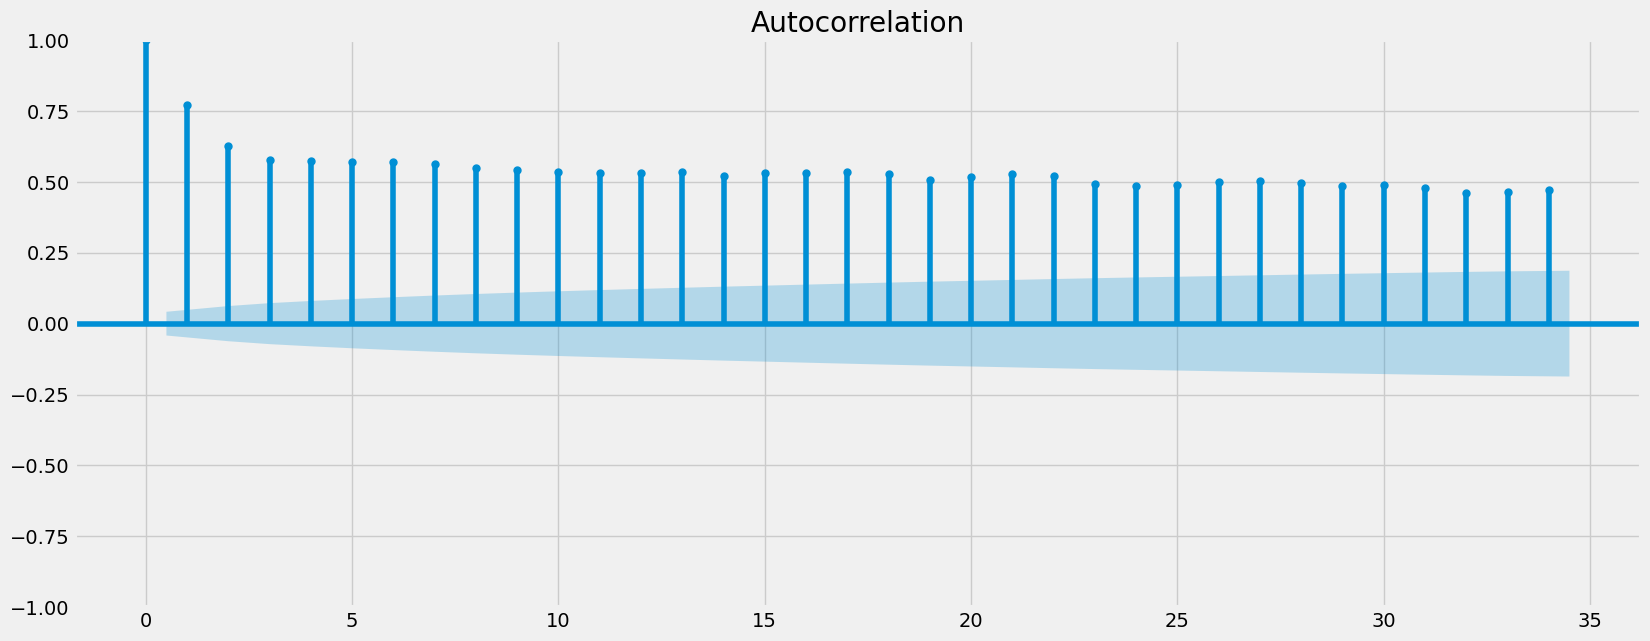

In [113]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_sub)
plt.show()

The Dickey-Fuller test is used to determine if a time series is stationary, meaning its statistical properties (like mean and variance) remain constant over time. The null hypothesis (H₀) assumes the series is non-stationary (i.e., it has a unit root).

From the test results:

The test statistic is -3.157673, which is more negative than the 5% critical value (-2.862873), but it does not pass the stricter 1% threshold (-3.433368).
The p-value is 0.022569, which is less than 0.05. This means we can reject the null hypothesis at the 5% significance level and conclude that the time series is stationary.
However, when we examine the autocorrelation plot (ACF), we notice that more than 10 lags fall outside the confidence bands, indicating significant autocorrelation in the data.

# 05. Stationarising the Data

In [117]:
df_diff = df_sub - df_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [119]:
df_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [121]:
df_diff.head()

Temp
datetime        
1985-01-02   1.9
1985-01-03  -2.1
1985-01-04  -0.4
1985-01-05   1.9
1985-01-06  -3.6

In [123]:
df_diff.columns

Index(['Temp'], dtype='object')

In [127]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_diff)

In [129]:
dickey_fuller(df_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.660016e+01
p-value                        1.767420e-29
Number of Lags Used            1.900000e+01
Number of Observations Used    2.169000e+03
Critical Value (1%)           -3.433368e+00
Critical Value (5%)           -2.862873e+00
Critical Value (10%)          -2.567480e+00
dtype: float64


In [133]:
plot_acf(df_diff)
plt.show()

After differencing the data, the new results show that the time series is now stationary. The Dickey-Fuller test has a test statistic of -16.60016, which is much lower than all the critical values (e.g., -3.433368 at the 1% level). This means we can confidently reject the null hypothesis that the data is non-stationary. Additionally, the p-value is effectively 0, providing strong evidence that the series is now stationary.

The autocorrelation plot (ACF) shows that most of the lags are now within the confidence intervals. This indicates that the differencing successfully removed the strong seasonality and any remaining patterns in the data. The series is now ready for modeling.

In summary, the data is stationary, and no further differencing is needed. 